In [28]:
from salad.serialize import read, write
from salad.analysis.plot import plot_cluster, plot_result, plot_fake, plot_catalog
import astropy.table
import os
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u

def load_recovery(pg, detector, snr):
    search_path = f"../search/tmp/DEEP/{pg}/detector_{detector}/snr_{snr}"
    
    catalog = read(os.path.join(search_path, "catalog.pkl"))
    recovery = read(os.path.join(search_path, "recovery.pkl"))
    catalog_findable = read(os.path.join(search_path, "catalog_detectable.pkl"))
    search_findable = read(os.path.join(search_path, "search_detectable.pkl"))
    detector_fakes = read(os.path.join(search_path, "..", "fakes.pkl"))
    clusters = read(os.path.join(search_path, "gather_2.pkl"))
    
    return catalog, detector_fakes, recovery, catalog_findable, search_findable, clusters


In [186]:
clusters[0].points

array([[ 2.16811736e+02, -1.10773691e+01,  5.85772654e+04],
       [ 2.16798576e+02, -1.10742333e+01,  5.85773489e+04],
       [ 2.16812337e+02, -1.10775773e+01,  5.85772620e+04],
       [ 2.16793317e+02, -1.10730413e+01,  5.85773820e+04],
       [ 2.16794963e+02, -1.10732715e+01,  5.85773717e+04],
       [ 2.16803361e+02, -1.10753701e+01,  5.85773176e+04],
       [ 2.16792980e+02, -1.10727439e+01,  5.85773837e+04],
       [ 2.16797940e+02, -1.10740745e+01,  5.85773523e+04],
       [ 2.16808685e+02, -1.10767019e+01,  5.85772848e+04],
       [ 2.16819016e+02, -1.10790977e+01,  5.85772191e+04],
       [ 2.16794350e+02, -1.10731633e+01,  5.85773751e+04],
       [ 2.16797336e+02, -1.10738037e+01,  5.85773557e+04],
       [ 2.16796283e+02, -1.10736954e+01,  5.85773626e+04],
       [ 2.16803823e+02, -1.10754054e+01,  5.85773159e+04],
       [ 2.16815203e+02, -1.10781956e+01,  5.85772431e+04],
       [ 2.16801592e+02, -1.10749305e+01,  5.85773296e+04],
       [ 2.16794094e+02, -1.10731103e+01

In [9]:
def filter_velocity(cluster, vmin=0.1 , vmax=0.5):
    p = cluster.points
    x, y = p[:, 2][:, None], p[:, :2]
#     regression_result = regression(x, y)
    regression_result = cluster.extra['line']
    v = ((regression_result.beta**2).sum()**0.5).value
#     print(v)
    return (v > vmin) and (v <= vmax)

def filter_n(cluster, n=15):
    return len(cluster.points) >= n


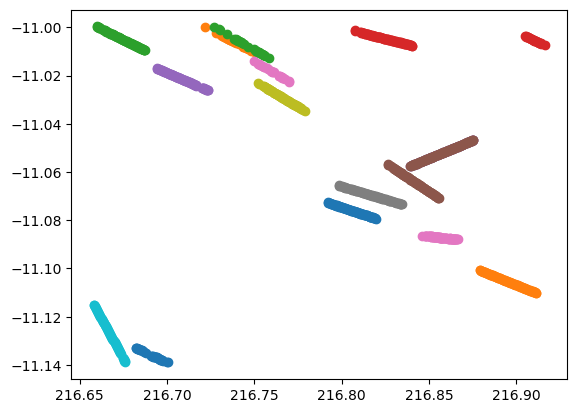

In [13]:
catalog, detector_fakes, recovery, catalog_findable, search_findable, clusters = load_recovery(
    "20190403/A0c", 3, 5
)

clusters = list(filter(filter_velocity, filter(filter_n, clusters)))
for cluster in clusters:
    plot_cluster(cluster)


In [23]:
import astropy.table

In [67]:
import lsst.daf.butler as dafButler

In [69]:
butler = dafButler.Butler("../data")

In [78]:
refs = list(
    butler.registry.queryDatasets(
        "differenceExp", 
        collections="DEEP/20190403/A0c",
        where="instrument='DECam' and exposure=845901"
    )
)

In [79]:
photo = butler.get(refs[0].makeComponentRef("photoCalib"))

In [80]:
photo.instFluxToMagnitude(18)

28.07459566761724

In [111]:
len(set(p['exposures'])) == len(p)

True

In [112]:
butler

In [116]:
import lsst.geom

lsst.geom.Box2I(lsst.geom.Point2I(10 - 5, 40 - 5), lsst.geom.Extent2I(-5, 5))

Box2I(corner=Point2I(1, 35), dimensions=Extent2I(5, 5))

In [164]:
from functools import lru_cache

@lru_cache(maxsize=512)
def _cutout(ref, x, y, w, h):
    corner = lsst.geom.Point2I(x - w/2, y - h/2)
    bbox = lsst.geom.Box2I(corner, lsst.geom.Extent2I(w, h))
    return butler.get(ref, parameters=dict(bbox=bbox))

def get_cutouts(p, pg, detector, w=50, h=50):
    import lsst.geom
    refs = butler.registry.queryDatasets(
        "differenceExp", 
        collections=f"DEEP/{pg}", 
        where="instrument='DECam' and visit in (" + ",".join(map(str, map(int, set(p['exposures'])))) + ")" + " and detector=" + str(detector)
    )
    refs = {ref.dataId['visit'] : ref for ref in refs}
    cutouts = []
    for row in p:
        visit = row['exposures']
        i_x, i_y = row['i_x'], row['i_y']        
        ref = refs[visit]
        cutout = _cutout(ref, i_x, i_y, w, h)
        cutouts.append(cutout)
    return cutouts

In [125]:
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend("matplotlib")

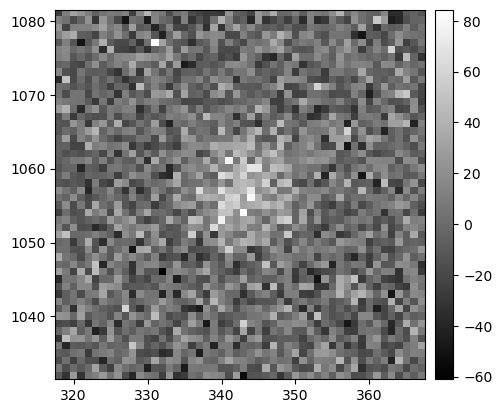

In [126]:
fig = plt.figure()
display = afwDisplay.Display(frame=fig)
display.mtv(cutouts[0])
plt.show()

In [154]:
import scipy 

# can I find the best fitting position?
# by how much can I shift the psf to maximize the flux, snr, or logL?
def logL_position(e, p, shift):
    eBBox = e.getBBox()
    psfBBox = e.psf.computeImageBBox(p)
    psfBBox.clip(eBBox)

    model = lsst.afw.image.ImageD(e.psf.computeImage(p), psfBBox).array
    model = scipy.ndimage.shift(model, shift)
    stamp = lsst.afw.image.ImageD(lsst.afw.image.ImageF(e.image, psfBBox), deep=True).array
    weights = 1/lsst.afw.image.ImageD(lsst.afw.image.ImageF(e.variance, psfBBox), deep=True).array
    a = np.sum(model * model * weights, axis=(0, 1))
    c = np.sum(model * stamp * weights, axis=(0, 1))
    f = c/a
    sigma = 1/np.sqrt(a)
    snr = c / np.sqrt(a)
    mag = e.getPhotoCalib().instFluxToMagnitude(f)
    sigma_mag_high = mag - e.getPhotoCalib().instFluxToMagnitude(f - sigma)
    sigma_mag_low = e.getPhotoCalib().instFluxToMagnitude(f + sigma) - mag

    logL = -0.5 * np.sum(weights * (f * model - stamp) ** 2)
    return {
        "logL": logL, 
        "a": a,
        "c": c,
        "flux": f, 
        "sigma": sigma, 
        "SNR": snr,
        "mag": mag,
        "sigma_mag_high": sigma_mag_high,
        "sigma_mag_low": sigma_mag_low,
    }

def fit_position(e, p, method="Nelder-Mead"):
    trace = []
    def f(x):
        trace.append(x)
        return -1 * logL_position(e, p, x)['logL']
    
    return trace, scipy.optimize.minimize(
        f, np.array([0, 0]),
        method=method
    )

def logL_trajectory(es, ps, times, trajectory, trajectory_params):
    position_result_keys = list(logL_position(es[0], ps[0], [0, 0]).keys())
    traj_result = {
        "position_" + k: [] for k in position_result_keys
    }
    ra, dec = trajectory(trajectory_params, times) # returns the predicted location at each time in degrees
    if np.any(np.array(dec) > 90) or np.any(np.array(dec) < -90):
        traj_result['logL'] = -np.inf
        return traj_result
    
    ra = list(map(lsst.geom.Angle, ra * np.pi/180))
    dec = list(map(lsst.geom.Angle, dec * np.pi/180))
    skyPoints = [lsst.geom.SpherePoint(r, d) for r, d in zip(ra, dec)]
    pixPoints = [e.wcs.skyToPixel(sp) for e, sp in zip(es, skyPoints)]
    # compute flux/logL for each exposure
    for e, p, p_traj in zip(es, ps, pixPoints):
        _position_result = logL_position(e, p, [p.y - p_traj.y, p.x - p_traj.x])
        for k in position_result_keys:
            traj_result["position_" + k].append(_position_result[k])

    traj_result['logL'] = np.sum(traj_result['position_logL'])
    return traj_result

def fit_trajectory(es, ps, times, trajectory, start=np.array([0, 0]), method="Nelder-Mead"):
    trace = []
    def f(x):
        trace.append(x)
        return -1 * logL_trajectory(es, ps, times, trajectory, x)['logL']
    return scipy.optimize.minimize(
        f, 
        start,
        method=method
    )


In [175]:
dafButler.Butler(
    "../data", 
    collections=f"DEEP/20190403/A0c", 
    instrument='DECam',
)

ERROR:lsst.daf.butler.direct_butler:Failed to instantiate Butler from config file:///data/epyc/projects/salad/data/butler.yaml.


TypeError: Only governor dimensions may be identified by a default data ID, not {'detector'}.  (These may just be unrecognized keyword arguments passed at Butler construction.)

In [135]:
from functools import lru_cache

@lru_cache(maxsize=512)
def _cutout(ref, x, y, w, h):
    corner = lsst.geom.Point2I(x - w/2, y - h/2)
    bbox = lsst.geom.Box2I(corner, lsst.geom.Extent2I(w, h))
    return butler.get(ref, parameters=dict(bbox=bbox))

def get_cutouts(p, pg, detector, w=50, h=50):
    import lsst.geom
    refs = butler.registry.queryDatasets(
        "differenceExp", 
        collections=f"DEEP/{pg}", 
        where="instrument='DECam' and visit in (" + ",".join(map(str, map(int, set(p['exposures'])))) + ")" + " and detector=" + str(detector)
    )
    refs = {ref.dataId['visit'] : ref for ref in refs}
    cutouts = []
    for row in p:
        visit = row['exposures']
        i_x, i_y = row['i_x'], row['i_y']        
        ref = refs[visit]
        cutout = _cutout(ref, i_x, i_y, w, h)
        cutouts.append(cutout)
    return cutouts

def measure(butler, catalog, clusters):
    x = catalog.X(columns=["i_x", "i_y", "ra", "dec", 'exposures', "time", "peakValue", "significance"])
    x = astropy.table.Table(
        x,
        names=['i_x', 'i_y', 'ra', 'dec', 'exposures', 'time', 'peakValue', 'significance']
    )
    x['flux'] = x['significance']**2 / x['peakValue']
    x['mag'] = photo.instFluxToMagnitudeArray(x['flux'], x['i_x'], x['i_y'])
    x['psi'] = x['peakValue']
    x['phi'] = (1 / x['significance']**2)*x['peakValue']**2
    
    for cluster in clusters:
        p = astropy.table.join(
            x,
            astropy.table.Table(
                clusters[i].points, 
                names=['ra', 'dec', 'time']
            ),
        )
        cutouts = get_cutouts(p, "20190403/A0c", detector)

In [153]:
p['peakValue']

26.175308227539062
25.863828659057617
25.65938377380371
31.842926025390625
22.02505111694336
33.90329360961914
36.11917495727539
29.224119186401367
36.47685241699219
32.19121551513672
44.4412841796875


In [168]:
x = catalog.X(columns=["i_x", "i_y", "ra", "dec", 'exposures', "time", "peakValue", "significance"])
x = astropy.table.Table(
    x,
    names=['i_x', 'i_y', 'ra', 'dec', 'exposures', 'time', 'peakValue', 'significance']
)
x['flux'] = x['significance']**2 / x['peakValue']
x['mag'] = photo.instFluxToMagnitudeArray(x['flux'], x['i_x'], x['i_y'])
x['psi'] = x['peakValue']
x['phi'] = (1 / x['significance']**2)*x['peakValue']**2

In [177]:
def measure(i):
    p = astropy.table.join(
        x,
        astropy.table.Table(
            clusters[i].points, 
            names=['ra', 'dec', 'time']
        ),
    )

    cutouts = get_cutouts(p, "20190403/A0c", detector)

    fluxes = []
    mags = []
    magerr_low = []
    magerr_high = []
    a = []
    c = []
    for cutout, row in zip(cutouts, p):
        result = logL_position(cutout, lsst.geom.Point2D(row['i_x'], row['i_y']), [0, 0])
        fluxes.append(result['flux'])
        mags.append(result['mag'])
        magerr_low.append(result['sigma_mag_low'])
        magerr_high.append(result['sigma_mag_high'])
        a.append(result['a'])
        c.append(result['c'])

    p['forced_flux'] = fluxes
    p['forced_mag'] = mags
    p['forced_mag_err_low'] = magerr_low
    p['forced_mag_err_high'] = magerr_high
    p['forced_a'] = a
    p['forced_c'] = c

    fig = plt.figure(figsize=(6, 6), dpi=150)
    ax = fig.add_subplot(221)
    plt.sca(ax)
    plt.scatter(p['ra'], p['dec'], s=1)
    plt.title("position")
    plt.xlabel("RA")
    plt.ylabel("Dec")

    ax = fig.add_subplot(222)
    plt.sca(ax)
    plt.scatter(p['time'], p['significance'], s=1)
    plt.title("SNR")
    plt.xlabel("time")

    ax = fig.add_subplot(223)
    plt.sca(ax)
    plt.errorbar(
        p['time'], p['forced_mag'], 
        yerr=[-p['forced_mag_err_low'], -p['forced_mag_err_high']], 
        fmt='o',
        ms=1, lw=1
    )
    plt.title("mag")
    plt.xlabel("time")

    ax = fig.add_subplot(224)
    plt.sca(ax)
    plt.scatter(p['time'], p['forced_flux'], s=1)
    plt.title("flux")
    plt.xlabel("time")

    fig.tight_layout()
    plt.show()
    return p
    

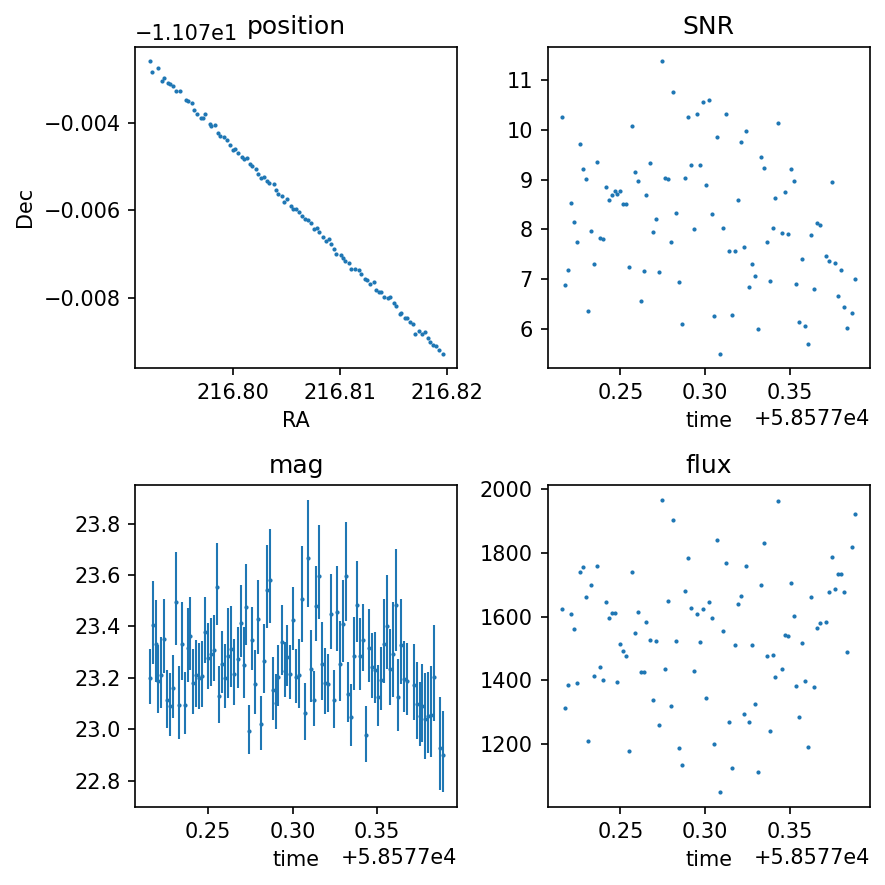

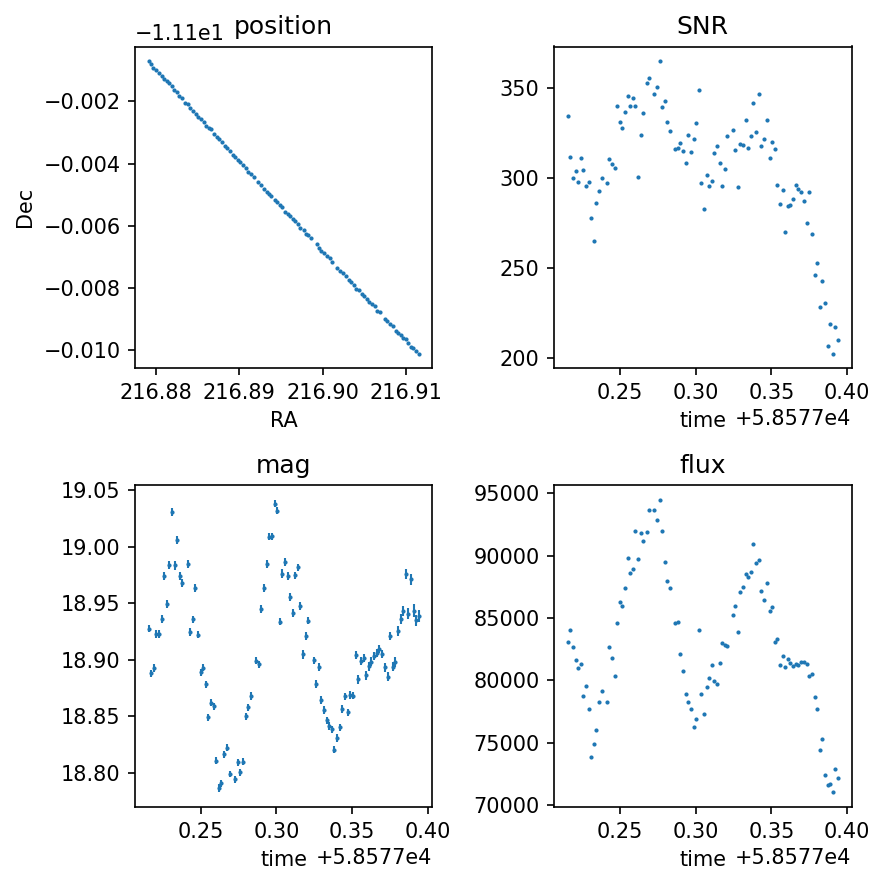

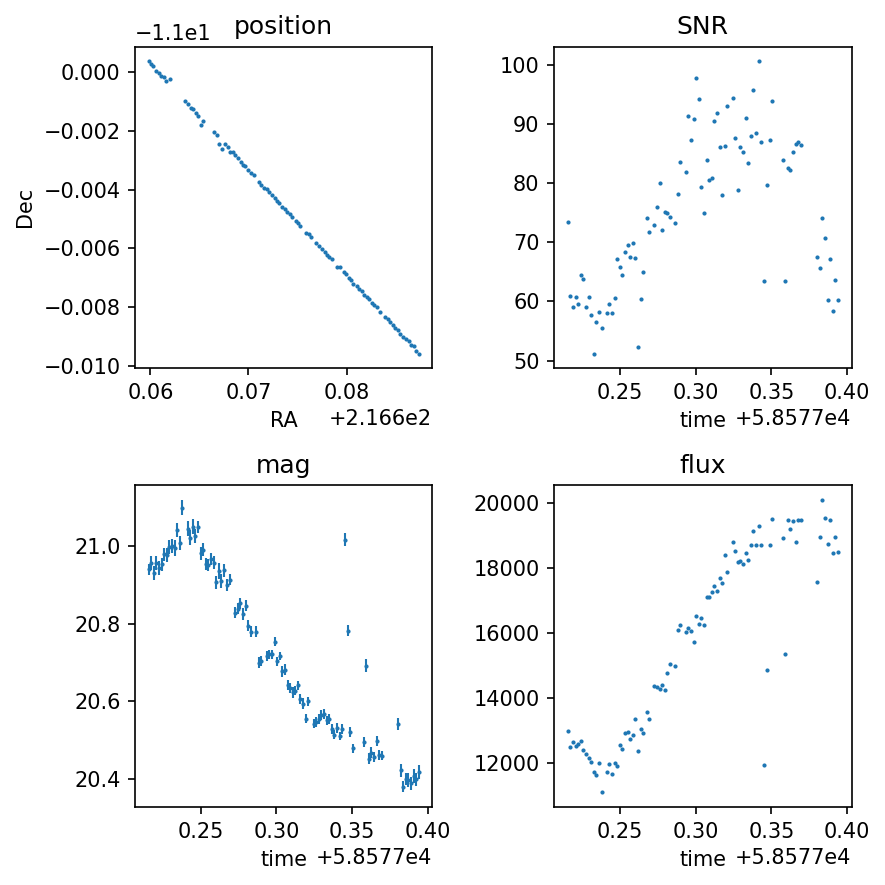

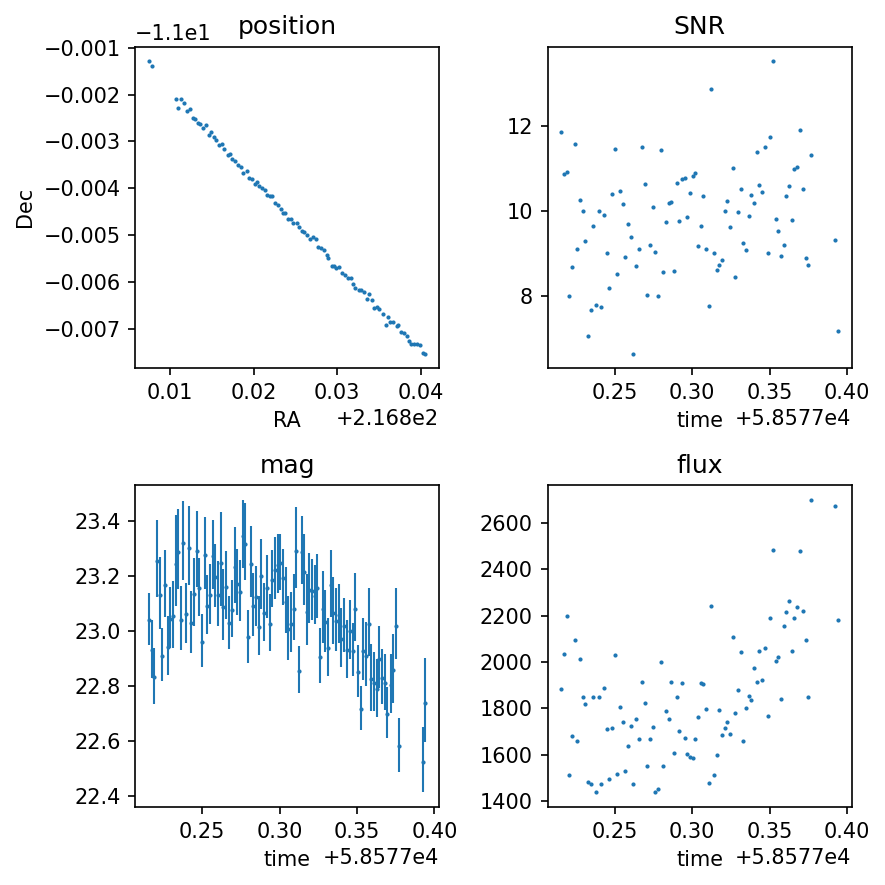

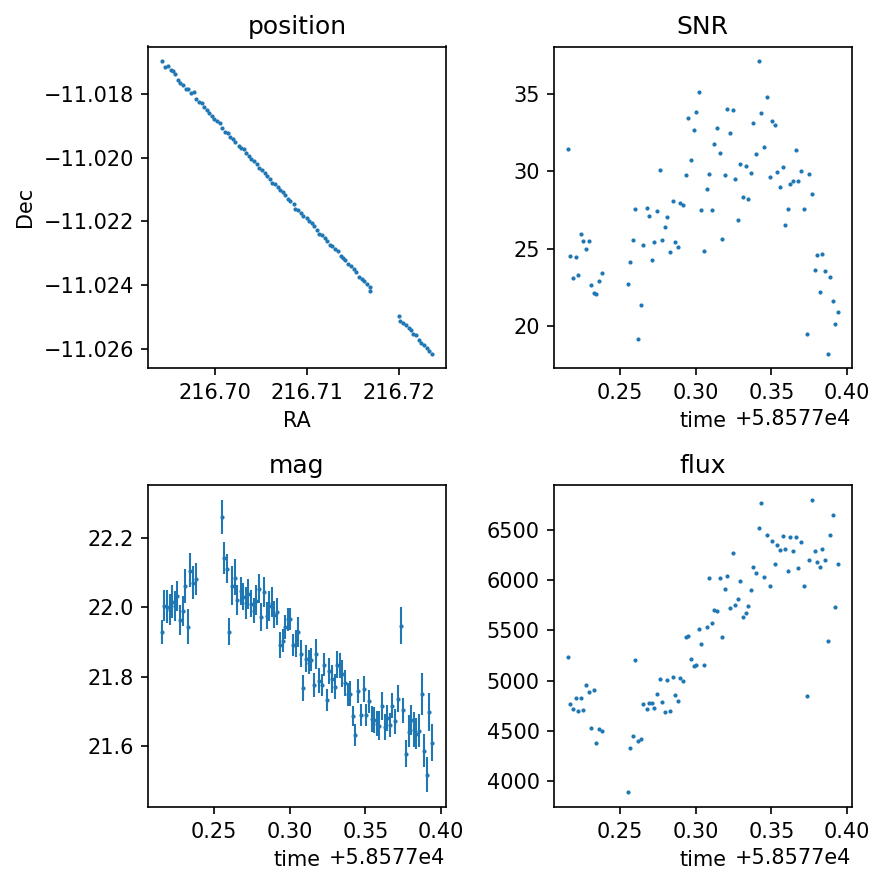

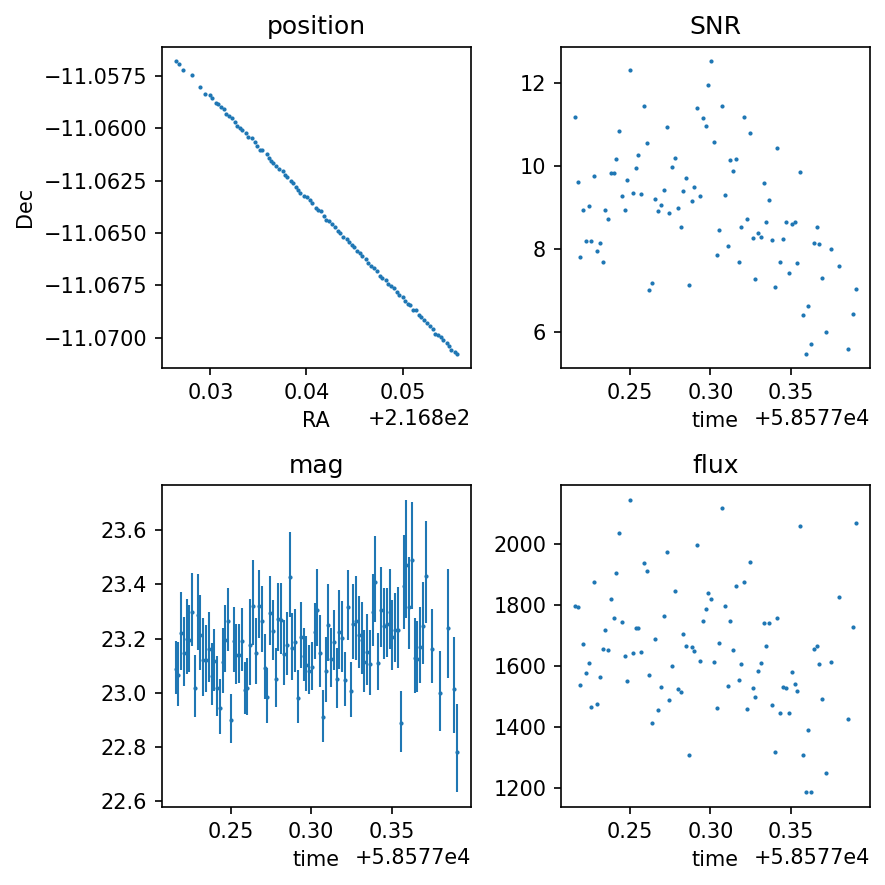

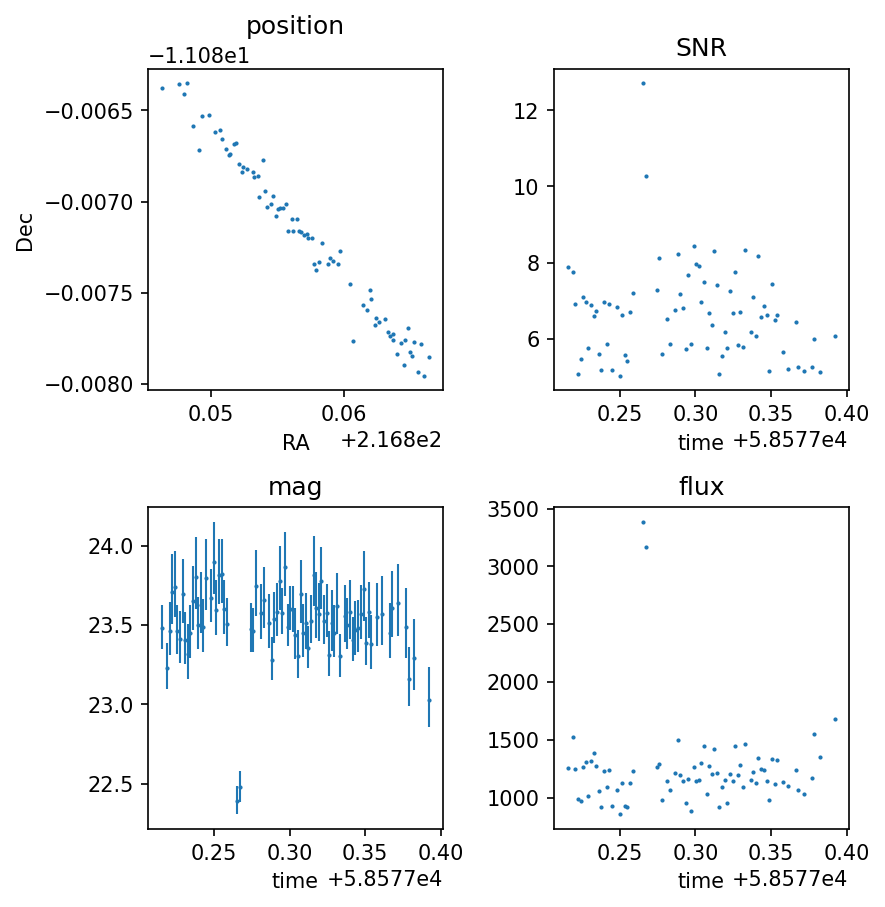

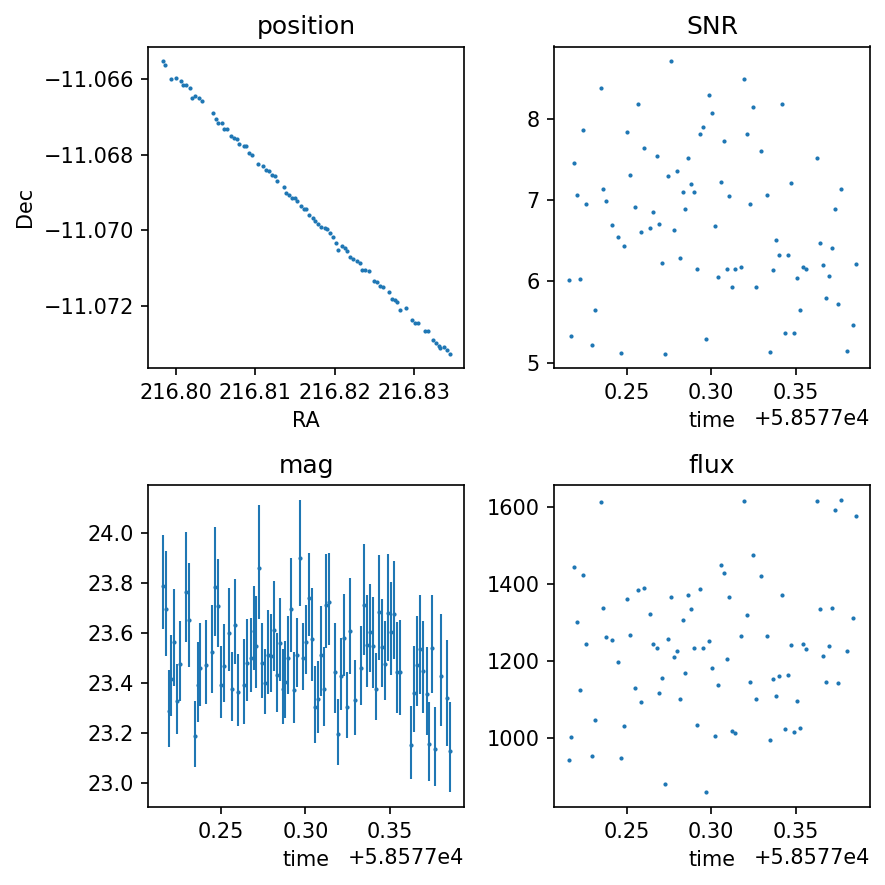

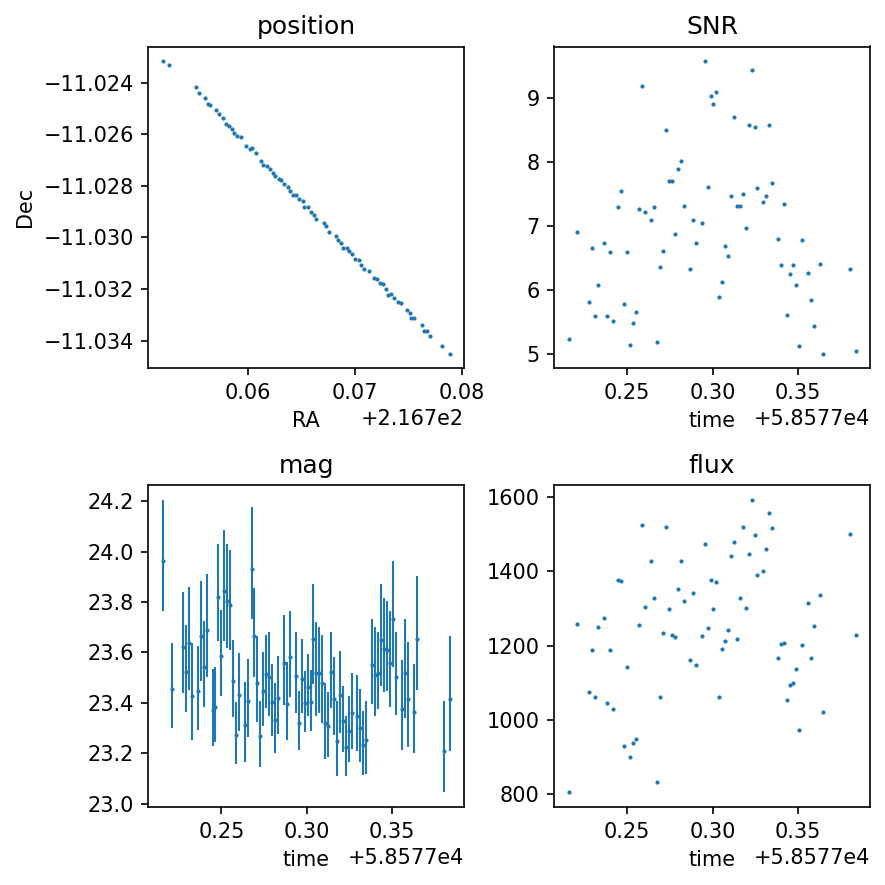

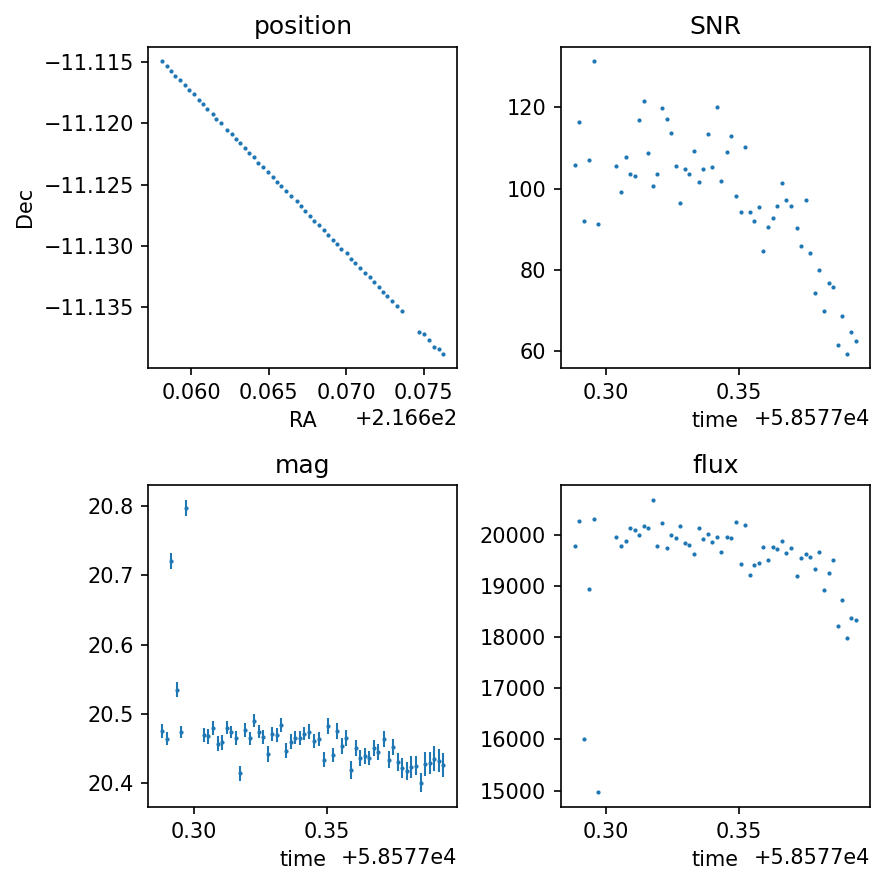

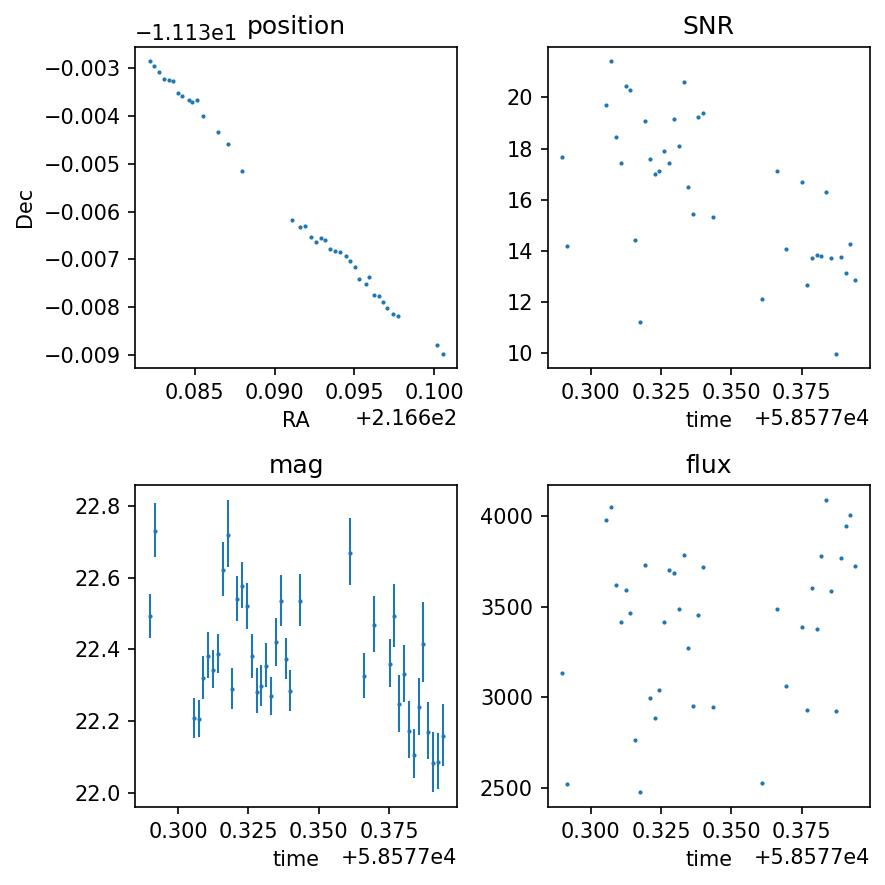

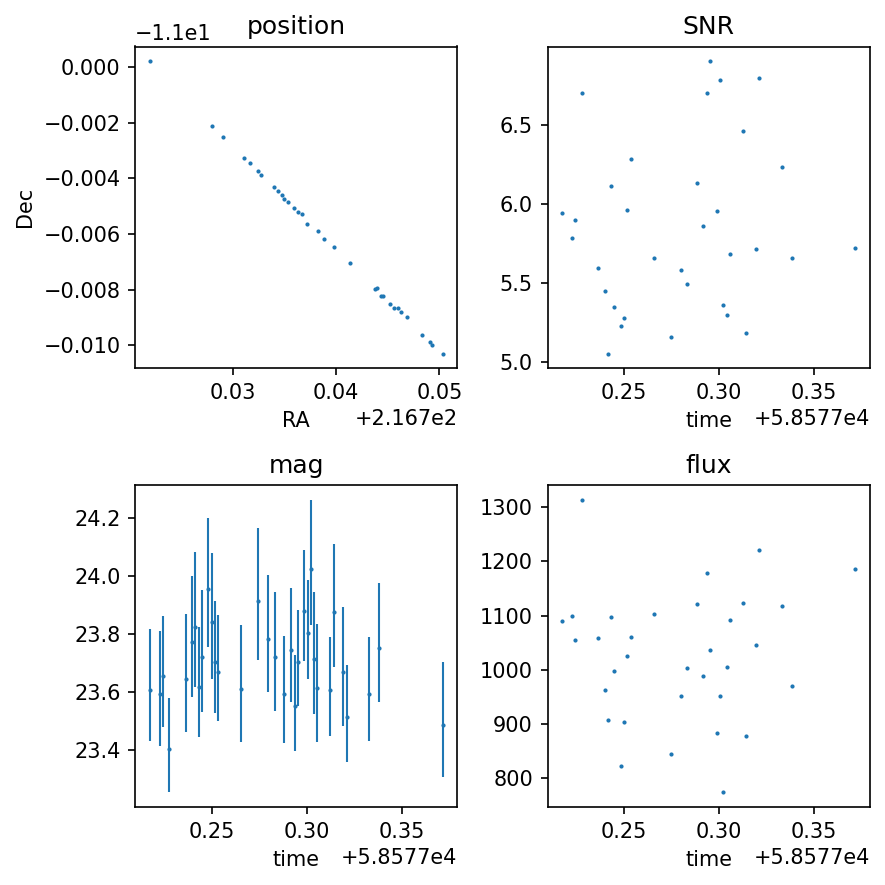

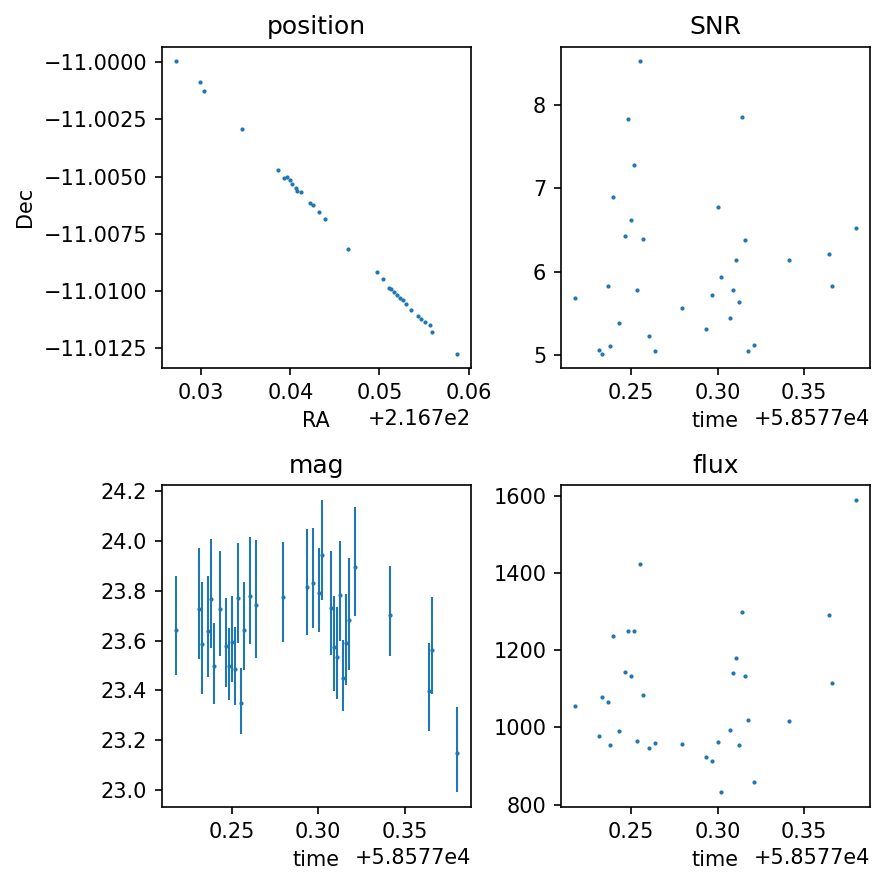

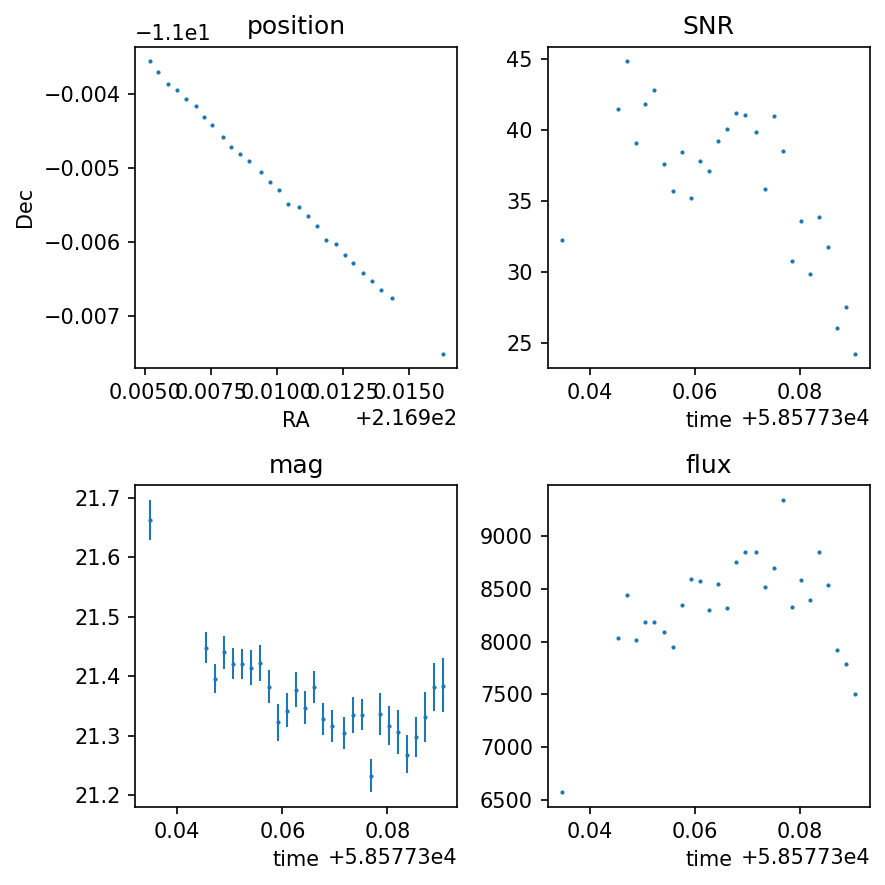

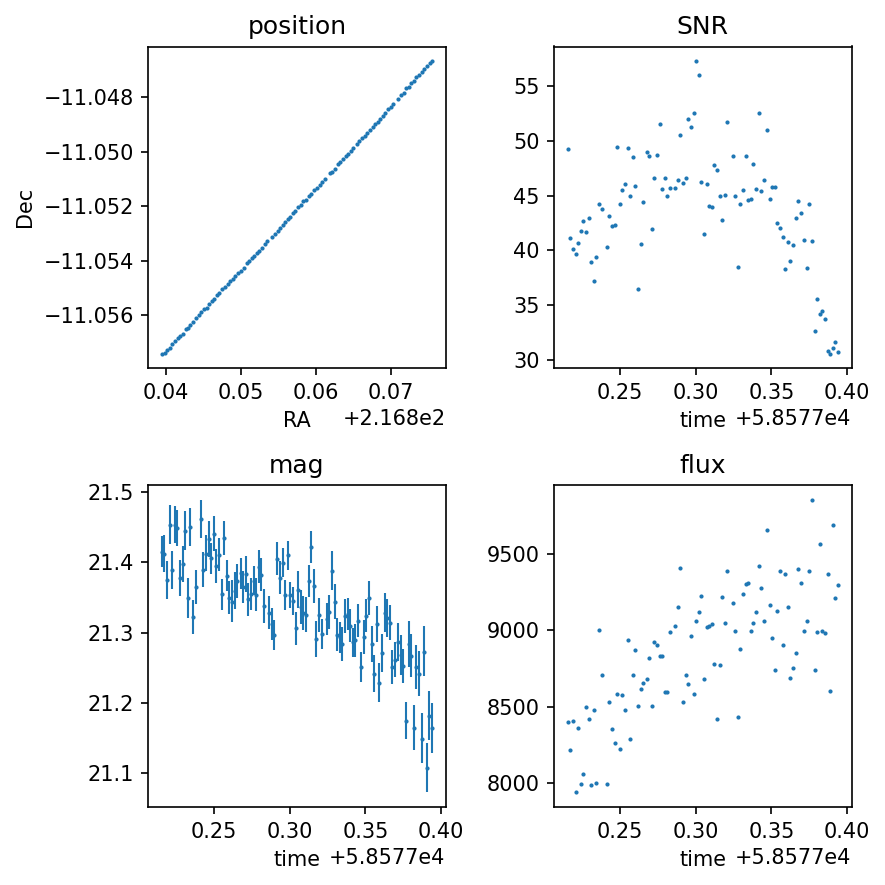

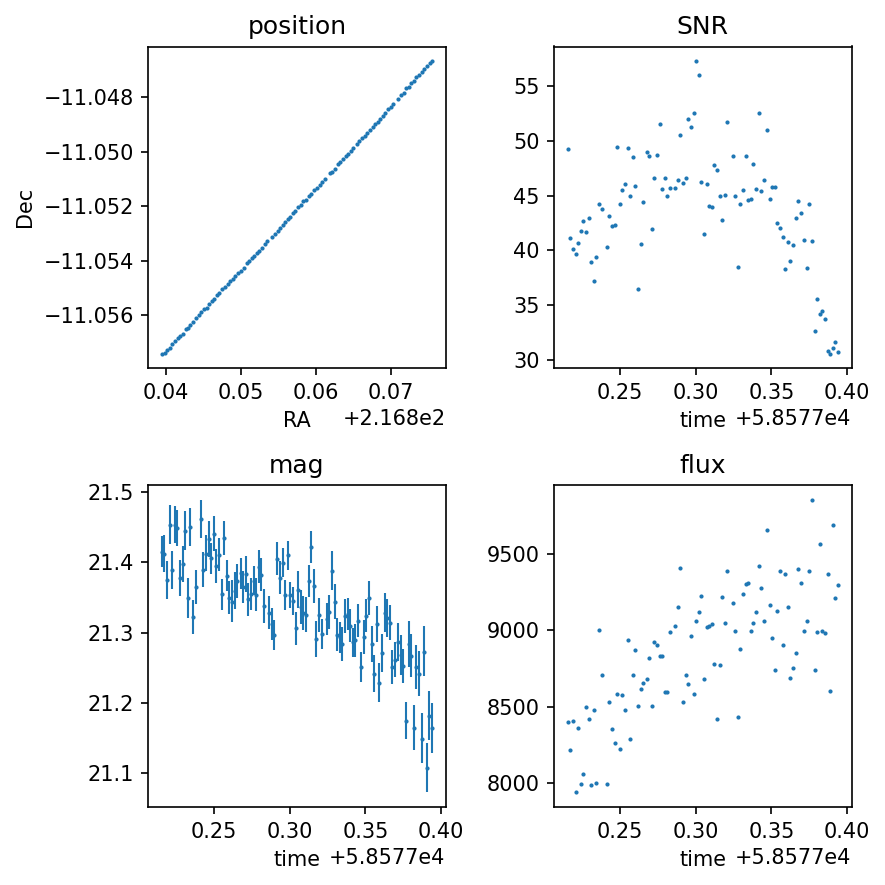

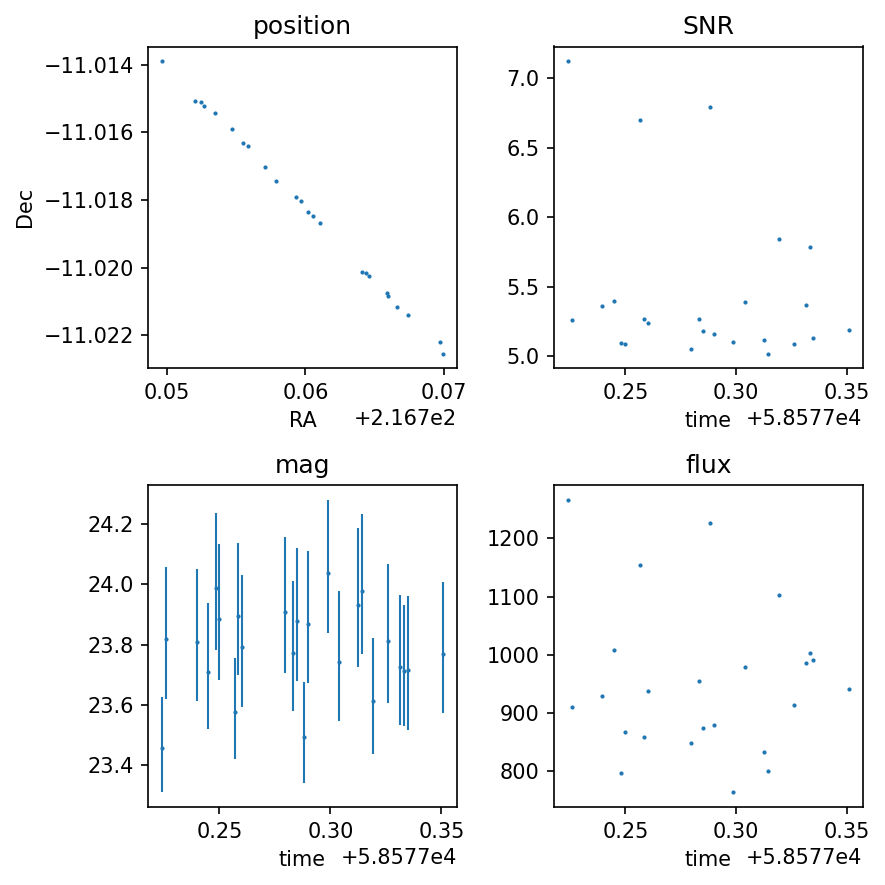

In [178]:
measurements = []
for i in range(len(clusters)):
    measurements.append(measure(i))
    

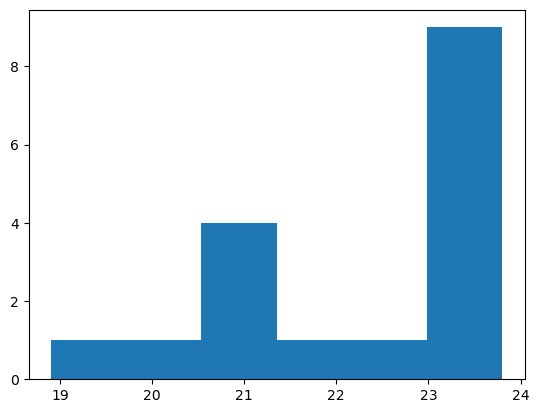

In [183]:
plt.hist(list(map(lambda x : np.nanmedian(x['forced_mag']), measurements)), bins='auto')
plt.show()

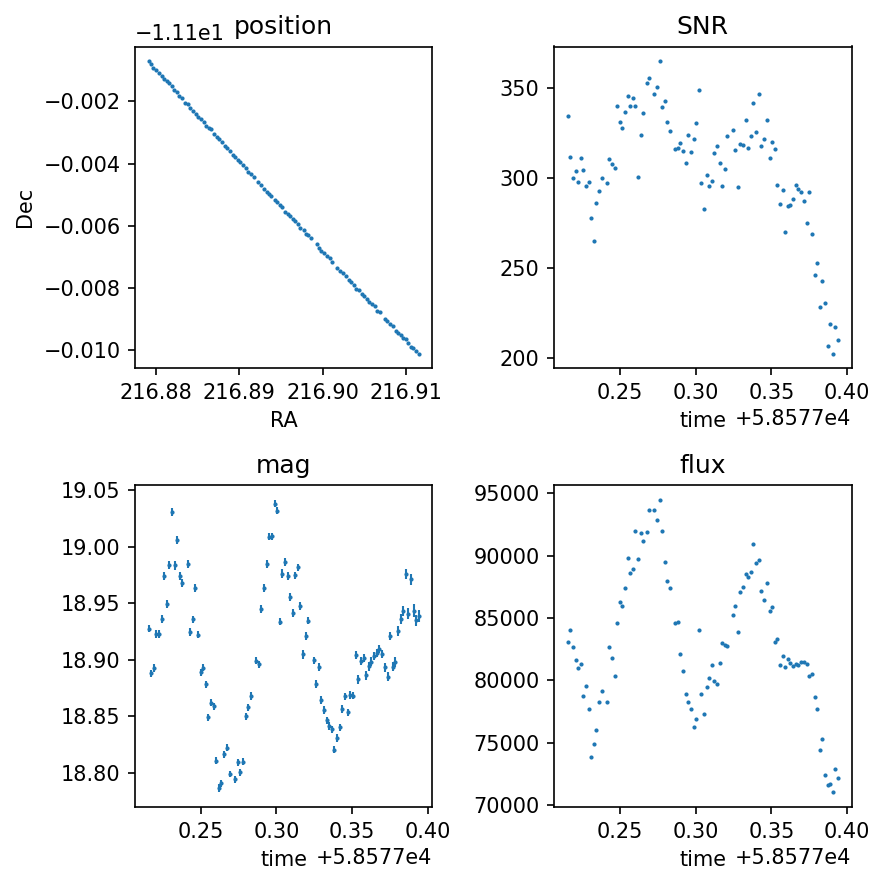

In [169]:
i = 2
detector = 3

p = astropy.table.join(
    x,
    astropy.table.Table(
        clusters[i].points, 
        names=['ra', 'dec', 'time']
    ),
)

cutouts = get_cutouts(p, "20190403/A0c", detector)

fluxes = []
mags = []
magerr_low = []
magerr_high = []
a = []
c = []
for cutout, row in zip(cutouts, p):
    result = logL_position(cutout, lsst.geom.Point2D(row['i_x'], row['i_y']), [0, 0])
    fluxes.append(result['flux'])
    mags.append(result['mag'])
    magerr_low.append(result['sigma_mag_low'])
    magerr_high.append(result['sigma_mag_high'])
    a.append(result['a'])
    c.append(result['c'])

p['forced_flux'] = fluxes
p['forced_mag'] = mags
p['forced_mag_err_low'] = magerr_low
p['forced_mag_err_high'] = magerr_high
p['forced_a'] = a
p['forced_c'] = c

fig = plt.figure(figsize=(6, 6), dpi=150)
ax = fig.add_subplot(221)
plt.sca(ax)
plt.scatter(p['ra'], p['dec'], s=1)
plt.title("position")
plt.xlabel("RA")
plt.ylabel("Dec")

ax = fig.add_subplot(222)
plt.sca(ax)
plt.scatter(p['time'], p['significance'], s=1)
plt.title("SNR")
plt.xlabel("time")

ax = fig.add_subplot(223)
plt.sca(ax)
plt.errorbar(
    p['time'], p['forced_mag'], 
    yerr=[-p['forced_mag_err_low'], -p['forced_mag_err_high']], 
    fmt='o',
    ms=1, lw=1
)
plt.title("mag")
plt.xlabel("time")

ax = fig.add_subplot(224)
plt.sca(ax)
plt.scatter(p['time'], p['forced_flux'], s=1)
plt.title("flux")
plt.xlabel("time")

fig.tight_layout()
plt.show()

In [173]:
clusters[i].extra

{'line': <salad.regression.RegressionResult at 0x7ff50f62d3d0>}

In [170]:
p

i_x,i_y,ra,dec,exposures,time,peakValue,significance,flux,mag,psi,phi,forced_flux,forced_mag,forced_mag_err_low,forced_mag_err_high,forced_a,forced_c
,,,,,,,,,mag(AB),,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1486.0,3542.0,216.87910751161888,-11.10071188890031,845975.0,58577.393984940834,299.8844909667969,210.13011169433594,147.23890421383243,25.792720488710206,299.8844909667969,2.0367204752575447,72134.09661334539,18.938981680013317,-0.005122207569247195,-0.005146487339430905,8.594159506833786e-06,0.6199319321764492
1487.0,3540.0,216.87938124897164,-11.100804588089302,845974.0,58577.39226360712,322.1417236328125,217.11929321289062,146.33555366146163,25.79940229272644,322.1417236328125,2.201390677607082,72905.50365430025,18.93516291255965,-0.00495355044602519,-0.004976254090347965,8.997309437285673e-06,0.6559533760589007
1497.0,3551.0,216.87966947470755,-11.100916922554251,845973.0,58577.390541809145,270.63092041015625,202.3211212158203,151.25336021467592,25.76351435129595,270.63092041015625,1.7892555909240373,70998.64531800176,18.94372474523706,-0.005327016506104343,-0.00535328170511562,8.200658984416014e-06,0.5822356786084371
1492.0,3558.0,216.8799890081472,-11.100995481923468,845972.0,58577.388831184246,348.815185546875,218.9972381591797,137.49341286892874,25.867072199927115,348.815185546875,2.5369592496725457,71680.9283053087,18.97140054503137,-0.004901361864039444,-0.004923588561716485,9.507067576568904e-06,0.6814754293497605
1495.0,3551.0,216.88034100043754,-11.101092424171082,845971.0,58577.387109267525,284.4176940917969,206.58245849609375,150.04802107887267,25.772201250203466,284.4176940917969,1.8955111306819092,71560.38324528027,18.940988614395206,-0.0052076786694357224,-0.005232777469668548,8.447555665470822e-06,0.6045103209069307
1497.0,3559.0,216.88067494871507,-11.101187893558288,845970.0,58577.385399164166,391.3674011230469,230.5135955810547,135.77144543778644,25.880755826441565,391.3674011230469,2.882545736042711,72383.4723738752,18.975978976656194,-0.004655750621296306,-0.004675800976723821,1.0335403300376502e-05,0.7481123792656611
1504.0,3567.0,216.8809403725263,-11.101282618486042,845969.0,58577.38366577728,425.5112609863281,242.9105682373047,138.66975934925054,25.85782252570391,425.5112609863281,3.068522387167667,75304.15283757342,18.943627956530772,-0.004422374944891061,-0.004440461671311624,1.0585956707692663e-05,0.7971665018480238
1501.0,3566.0,216.88127997098556,-11.10136087490578,845968.0,58577.38195688883,349.3583984375,228.21441650390625,149.07848253585294,25.779239521781875,349.3583984375,2.343452874585575,74410.68087659855,18.936321915585822,-0.004705879474688146,-0.004726364872819744,9.572237188649461e-06,0.7122766867197039


In [98]:
p['psi'].sum() / p['phi'].sum()**0.5

270.6178265611818

In [99]:
p['psi'] / p['phi']

16.70326454484098
15.632482726543582
18.23833816251667
16.893077526569957
15.069724563155397
16.370302134370778
16.809239642479106
16.886100111302095
16.591549528661016
17.298921976215944
18.32562465466682


In [60]:
flux = catalog.significance**2 / catalog.peakValue

In [ ]:
# x = a / sqrt(b)
# y = a
# z = a / b
# sqrt(b) = y / x
# b = (y / x)**2
# z = y / (y / x)**2
# z = x**2 / y